In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import mat73
import time

# ------------------     MATLAB STUFF  ----------------------------------
def get_matlab_variables(mat_file_path):
    variables = mat73.loadmat(mat_file_path)
    #double gets converted to np array by default
    value_func_data = variables['Vx']
    lx_data = variables['lx'] 
    tau2 = variables['tau2']

    #Deriv is cell which gets converted into list of lists
    deriv_v_data = np.array(variables['Deriv'][2])
    deriv_v_data = deriv_v_data.squeeze()
    deriv_th_data = np.array(variables['Deriv'][3])
    deriv_th_data = deriv_th_data.squeeze()

    #g is struct whic gets converted into dic
    #vs is cell which give a list
    x_coord=np.array(variables['g']['vs'][0])
    y_coord=np.array(variables['g']['vs'][1])
    v_coord=np.array(variables['g']['vs'][2])
    th_coord=np.array(variables['g']['vs'][3])
    x_coord = x_coord.squeeze()
    y_coord = y_coord.squeeze()
    v_coord = v_coord.squeeze()
    th_coord = th_coord.squeeze()

    matlab_var_dict = dict( value_func_data=value_func_data,
                            lx_data=lx_data,
                            deriv_v_data=deriv_v_data,
                            deriv_th_data=deriv_th_data,
                            x_coord=x_coord,
                            y_coord=y_coord,
                            v_coord=v_coord,
                            th_coord=th_coord,
                            tau2=tau2
                           )
    return matlab_var_dict

def get_value_func_eval_function(matlab_var_dict):
   val_func_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['v_coord'], matlab_var_dict['th_coord']), matlab_var_dict['value_func_data'] ,  bounds_error=False, fill_value=None)
   return val_func_eval

def get_lx_eval_function(matlab_var_dict):
   lx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord']), matlab_var_dict['lx_data'] ,  bounds_error=False, fill_value=None)
   return lx_eval

def get_deriv_v_function(matlab_var_dict):
   deriv_v_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['v_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_v_data'] ,  bounds_error=False, fill_value=None)
   return deriv_v_eval

def get_deriv_th_function(matlab_var_dict):
   deriv_th_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['v_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_th_data'] ,  bounds_error=False, fill_value=None)
   return deriv_th_eval

def get_opt_control( deriv_v_eval ,deriv_th_eval, state, aMax, angleMax, u_mode = 'max'):
    # uOpt{1} = (deriv{3}>=0)*obj.accMax   + (deriv{3}<0)*(-obj.accMax) ;   %acceleration control
    # uOpt{2} = (deriv{4}>=0)*obj.angleMax + (deriv{4}<0)*(-obj.angleMax);  %steering control
    v_deriv = deriv_v_eval(state)
    th_deriv = deriv_th_eval(state)
    if u_mode == 'max':
        opt_a = aMax * ( v_deriv >= 0 ) + (-aMax) * ( v_deriv < 0 )
        opt_angle = angleMax * ( th_deriv >= 0 ) + (-angleMax) * ( th_deriv < 0 )
    else:
        raise NotImplementedError
    return opt_a, opt_angle

#---------------------- Load MATLAB ---------------------------------------------------------
#v2 baseline brt
#v3 1m/s speed lower bound in lx
matlab_var_dict= get_matlab_variables('C:\\Users\\javie\\Documents\\reachability_w_levelset\\Level_set_work\\mppi_safe\\rc_car\\brt_rc_v4.mat')
data = matlab_var_dict['value_func_data']
data_lx = matlab_var_dict['lx_data']
val_fun = get_value_func_eval_function(matlab_var_dict)
lx_fun = get_lx_eval_function(matlab_var_dict)
deriv_v_eval = get_deriv_v_function(matlab_var_dict)
deriv_th_eval = get_deriv_th_function(matlab_var_dict)


In [2]:
#rc car dynamics
def rc_dyn(state, control):
    #  dx{1} = x{3} .* cos(x{4});
    # dx{2} = x{3} .* sin(x{4});
    # dx{3} = u{1};
    # dx{4} = x{3} .* tan(u{2}) * (1/obj.L);
    x = state[0]
    y = state[1]
    v = state[2]
    th = state[3]

    x_dot = v * np.cos(th) 
    y_dot = v * np.sin(th) 
    v_dot = control[0]
    th_dot = v * np.tan(control[1]) * (1/0.3) #0.3 is the length of the car

    state_dot = np.array([x_dot, y_dot, v_dot, th_dot])
    return state_dot

#TVD Runge-Kutta 3rd order
def TVD_rk3(s0, dyn, control, dt):
    s1 = s0 + dyn(s0, control)*dt
    s2 = s1 + dyn(s1, control)*dt
    s_half = 0.75*s0 + 0.25*s2
    s_three_half = s_half + dyn(s_half, control)*dt
    s1_new = 1/3 * s0 + 2/3 * s_three_half
    #handle periodicity on the orientation (4th dim)
    if s1_new[3] > np.pi:
        s1_new[3] = s1_new[3] - 2*np.pi
    if s1[3] < -np.pi:
        s1_new[3] = s1_new[3] + 2*np.pi
    return s1_new

def forward_euler(s0, dyn, control, dt):
    s1 = s0 + dyn(s0, control)*dt
    #handle periodicity on the orientation (4th dim)
    if s1[3] > np.pi:
        s1[3] = s1[3] - 2*np.pi
    if s1[3] < -np.pi:
        s1[3] = s1[3] + 2*np.pi
    return s1

def MPPI(horzn,threads,x_0,dt,lx_fun,val_fun,u_a_plan,u_angle_plan,aMax,angleMax,lamd,filter_hallucinations,epsilon,deriv_v_eval,deriv_th_eval,get_opt_control):
    start = time.time()
    cost_list = np.zeros((threads, 1))
    cost_list[:] = np.nan
    a_control_list = np.zeros((threads, horzn))
    a_control_list[:] = np.nan
    angle_control_list = np.zeros((threads, horzn))
    angle_control_list[:] = np.nan
    list_hallucinations = []

    #get rid of the last term in the plan
    u_a_plan[-1] = 0.0
    u_angle_plan[-1] = 0.0

    for i in range(threads):
        cost = 0.0
        x_seq = np.zeros((horzn+1, 4))
        x_seq[0] = x_0
        a_seq = np.random.normal(0,aMax,horzn) + u_a_plan
        a_seq = np.clip(a_seq, -aMax, aMax)
        angle_seq = np.random.normal(0,angleMax,horzn) + u_angle_plan
        angle_seq = np.clip(angle_seq, -angleMax, angleMax)
        
        for j in range(horzn):
            cost = cost + np.linalg.norm(x_seq[j,2] - 3.5) #cost for being off the desired speed
            lx = lx_fun(x_seq[j][0:2])
            cost = cost - 5*lx #cost for not being centered in the lane
            if lx < 0 or x_seq[j,2]<1.0:
                cost = cost + 1000
                #break
            #propagate the dynamics
            x_seq[j+1] = forward_euler(x_seq[j], rc_dyn, [a_seq[j],angle_seq[j]], dt)
            if filter_hallucinations and val_fun(x_seq[j+1]) < epsilon and j < horzn-1:
                a_seq[j+1], angle_seq[j+1] = get_opt_control(deriv_v_eval, deriv_th_eval, x_seq[j+1], aMax, angleMax)                           

        cost_list[i] = cost
        a_control_list[i] = a_seq
        angle_control_list[i] = angle_seq
        list_hallucinations.append(x_seq[:,0:2])        

        # if time.time() - start > dt*0.9:
        #     break

    #print the number of threads used
    print('threads used: '+ str(i+1))
    #remove nan cost rows
    cost_list = cost_list[~np.isnan(cost_list).any(axis=1)]
    #remove nan control rows
    a_control_list = a_control_list[~np.isnan(a_control_list).any(axis=1)]  
    angle_control_list = angle_control_list[~np.isnan(angle_control_list).any(axis=1)]
    #wheight of each candidate control sequence
    wht = np.exp(-lamd*(cost_list-np.min(cost_list)))
    #wheighted sum of the controls
    u_a_plan = np.sum(wht*a_control_list, axis=0)/np.sum(wht)
    u_angle_plan = np.sum(wht*angle_control_list, axis=0)/np.sum(wht)
    return u_a_plan, u_angle_plan, list_hallucinations


In [3]:
#Simulation parameters
T_HORIZON = 5.0
DT=0.05
SIM_HORIZON = int(T_HORIZON/DT)

#MPPI parameters
OPT_HORIZON = 20
OPT_THREADS = 40
u_a_plan = np.zeros(OPT_HORIZON)
u_angle_plan = np.zeros(OPT_HORIZON)
LAMBDA = 1000

#control parameters
aMax = 1.5
angleMax = np.pi/12
epsilon = 0.15
filter_hallucinations = False

# trajectory initialization
x0 = np.array([3.3, 1.5, 2, np.pi/2])
#check if the initial state is inside the BRT
value_0 = val_fun(x0)
print('value at initial state: ', value_0)

x_t = np.zeros((SIM_HORIZON, 4))
u_t = np.zeros((SIM_HORIZON, 2))
lx_t = np.zeros((SIM_HORIZON, 1))
val_t = np.zeros((SIM_HORIZON, 1))
m_t = np.zeros((SIM_HORIZON, 3))
idx_first_fltr = 0
list_hallucinations_at_idx = []

x_t[0]=x0
u=np.array([0.0, 0.0])

for i in range(0, SIM_HORIZON-1):
 
    #get the obstacle penetration and value at the current state
    lx_now = lx_fun(x_t[i][0:2])
    value_now = val_fun(x_t[i])
    lx_t[i] = lx_now
    val_t[i] = value_now
    if lx_now < 0:
        print('collision!')
        break
    
#get the optimal control
# if value_now < 500:
#     u[0], u[1] = get_opt_control(deriv_v_eval, deriv_th_eval, x_t[i], aMax, angleMax)
#     m_t[i] = [0.9,0.2,0.2]
#     if idx_first_fltr == 0:
#         idx_first_fltr = i
# else:        
    u_a_plan, u_angle_plan, list_hallucination = MPPI(OPT_HORIZON, OPT_THREADS, x_t[i], DT,
                                                        lx_fun, val_fun, u_a_plan, u_angle_plan, aMax, angleMax,
                                                        LAMBDA, filter_hallucinations, epsilon, deriv_v_eval, deriv_th_eval, get_opt_control)
    u[0]=u_a_plan[0]
    u[1]=u_angle_plan[0]
    list_hallucinations_at_idx.append(list_hallucination)
    m_t[i] = [0.4,0.4,0.8]
    #make the plan shift one step, the control used now ends up in last term. We take care of that in MPPI call
    u_a_plan = np.roll(u_a_plan,-1) 
    u_angle_plan = np.roll(u_angle_plan,-1)  
    
    #propagate the system using the filtered control
    x_t[i+1] = TVD_rk3(x_t[i], rc_dyn, u, DT)
    u_t[i] = u

#remove all rows after the last step
x_t = x_t[:i+2]
u_t = u_t[:i+1]
val_t = val_t[:i+1]
m_t = m_t[:i+2]
print('done in ', i, ' steps')


value at initial state:  [0.40716117]
threads used: 40


C:\Users\javie\AppData\Local\Temp\ipykernel_25492\2339805682.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a_seq[j+1], angle_seq[j+1] = get_opt_control(deriv_v_eval, deriv_th_eval, x_seq[j+1], aMax, angleMax)


threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 40
threads used: 

[x,y,v,th]
[ 0.65  3.97  3.3  -1.67]


C:\Users\javie\AppData\Local\Temp\ipykernel_25492\3786608654.py:19: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in CP1.collections:
C:\Users\javie\AppData\Local\Temp\ipykernel_25492\3786608654.py:27: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in CP2.collections:


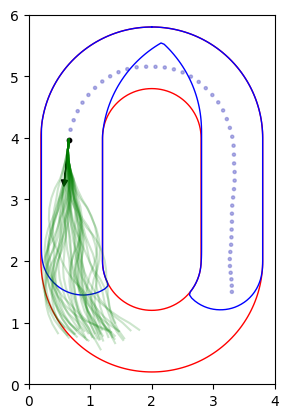

In [4]:
from ipywidgets import interact

idx_to_plot = 45

#def plot_func(idx_to_plot):
    
state_plot = x_t[idx_to_plot]
#print the state with 2 decimals
print('[x,y,v,th]')
print(np.around(state_plot, decimals=2))
#get the index of the closest v and th to the state_first_fltr
v_idx = np.argmin(np.abs(matlab_var_dict['v_coord'] - state_plot[2]))
th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - state_plot[3]))

f1, ax1 = plt.subplots()
data1 = data_lx
data1 = data1.transpose()
CP1 = ax1.contour(matlab_var_dict['x_coord'],matlab_var_dict['y_coord'],data1,0)
for c in CP1.collections:
    c.set_edgecolor("red")
    c.set_linewidth(1)
    c.set_label("")

data2 = data[:,:,v_idx,th_idx] #slice of lx
data2 = data2.transpose()
CP2 = ax1.contour(matlab_var_dict['x_coord'],matlab_var_dict['y_coord'],data2,0)
for c in CP2.collections:
    c.set_edgecolor("blue")
    c.set_linewidth(1)
    c.set_label("")

#plot an arrow with angle theta
th=matlab_var_dict['th_coord']
th = th[th_idx]

SP1 = ax1.scatter(x_t[0:idx_to_plot,0], x_t[0:idx_to_plot,1],s=5,c=m_t[0:idx_to_plot], alpha=0.5)
SP2 = ax1.scatter(x_t[idx_to_plot,0], x_t[idx_to_plot,1],s=10, c=[[0.0,0.0,0.0]], alpha=1.0)
#plot the arrow
ax1.arrow(x_t[idx_to_plot,0], x_t[idx_to_plot,1], x_t[idx_to_plot,2]*np.cos(th)*0.2, x_t[idx_to_plot,2]*np.sin(th)*0.2, head_width=0.1, head_length=0.1, fc='k', ec='k')

#plot the hallucinations corresponding to idx_to_plot
for h in list_hallucinations_at_idx[idx_to_plot]:
    #remove zero rows
    h = h[~np.all(h == 0, axis=1)]
    ax1.plot(h[:,0], h[:,1], color='green', alpha=0.2)

#set x and y limits
ax1.set_xlim([0, 4])
ax1.set_ylim([0, 6])

#change aspect ratio to match the grid
ax1.set_aspect('equal')
plt.show()

#interact(plot_func, idx_to_plot=(0, i, 1))

